In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from LoadData import loaddata, filter_zeroes, filter_data
import torch
from torch.utils.data import TensorDataset, DataLoader

simulation_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine']
data = loaddata(simulation_names)
filtered_AH, filtered_mass_presentsfr, filtered_labels = filter_data(data)

In [2]:
filtered_AH.shape, filtered_mass_presentsfr.shape, filtered_labels.shape

((63083, 139), (63083, 2), (63083,))

In [3]:
SFH_train_val, SFH_test, labels_train_val, labels_test, mass_sfr_train_val, mass_sfr_test = train_test_split(
    filtered_AH, filtered_labels, filtered_mass_presentsfr, test_size=0.2, random_state=42)

SFH_train, SFH_val, labels_train, labels_val, mass_sfr_train, mass_sfr_val = train_test_split(
    SFH_train_val, labels_train_val, mass_sfr_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 validation
# 20% Test, 20% Validation, 60% Training

SFH_train_tensor = torch.tensor(SFH_train, dtype=torch.float32)
SFH_val_tensor = torch.tensor(SFH_val, dtype=torch.float32)
SFH_test_tensor = torch.tensor(SFH_test, dtype=torch.float32)

labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.float32)

mass_sfr_train_tensor = torch.tensor(mass_sfr_train, dtype=torch.float32)
mass_sfr_val_tensor = torch.tensor(mass_sfr_val, dtype=torch.float32)
mass_sfr_test_tensor = torch.tensor(mass_sfr_test, dtype=torch.float32)

train_dataset = TensorDataset(SFH_train_tensor, labels_train_tensor, mass_sfr_train_tensor)
val_dataset = TensorDataset(SFH_val_tensor, labels_val_tensor, mass_sfr_val_tensor)
test_dataset = TensorDataset(SFH_test_tensor, labels_test_tensor, mass_sfr_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [10]:
import random

# Set seed for reproducibility
seed = 130
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Ensures determinism


device = torch.device("mps") # MPS on Mac
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=4, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=4, padding=1)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.fc1 = nn.Linear(16 * 7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)  # Latent space
        
        # Decoder (Pathway 1)
        self.fc4 = nn.Linear(16, 32)
        self.fc5 = nn.Linear(32, 64)
        self.fc6 = nn.Linear(64, 16 * 7)
        self.deconv1 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=4, stride=2)
        self.deconv2 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=4, stride=2)
        self.deconv3 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        self.deconv4 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, stride=2)

        # Pathway 2: MLP for simulation type classification
        self.fc_sim1 = nn.Linear(16, 100)
        self.fc_sim2 = nn.Linear(100, 100)
        self.fc_sim3 = nn.Linear(100, 10)
        
        # Pathway 3: MLP for SM and SFR prediction
        self.fc_sfr1 = nn.Linear(16, 200)
        self.fc_sfr2 = nn.Linear(200, 200)
        self.fc_sfr3 = nn.Linear(200, 200) 
        self.fc_sfr4 = nn.Linear(200, 2)  # Predicting SM and SFR

    def encoder(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 16 * 7)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        encoded = self.fc3(x)
        return encoded

    def decoder(self, x):
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = x.view(-1, 16, 7)
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.relu(self.deconv3(x))
        x = torch.relu(self.deconv4(x))
        return x

    def sim_type_classifier(self, x):
        x = torch.relu(self.fc_sim1(x))
        x = torch.relu(self.fc_sim2(x))
        sim_type_output = self.fc_sim3(x)
        return sim_type_output

    def sfr_predictor(self, x):
        x = torch.relu(self.fc_sfr1(x))
        x = torch.relu(self.fc_sfr2(x))
        x = torch.relu(self.fc_sfr3(x))
        sfr_output = self.fc_sfr4(x)
        return sfr_output
    
    def forward(self, x):
        latent = self.encoder(x)
        
        # Pathway 1: Reconstruct SFH
        sfh_output = self.decoder(latent)
        
        # Pathway 2: Classify sim type
        sim_type_output = self.sim_type_classifier(latent)
        
        # Pathway 3: Predict SM and SFR
        sfr_output = self.sfr_predictor(latent)
        
        return sfh_output, sim_type_output, sfr_output

def compute_loss(sfh_output, sfh_target, sim_type_output, sim_type_target, mass_sfr_output, mass_sfr_target, w_reg, w_cl):
    mse_loss = nn.MSELoss()
    cross_entropy_loss = nn.CrossEntropyLoss()

    loss_sfh = mse_loss(sfh_output, sfh_target)
    loss_sim_type = cross_entropy_loss(sim_type_output, sim_type_target)
    loss_mass_sfr = mse_loss(mass_sfr_output, mass_sfr_target)

    total_loss = loss_sfh + w_reg * loss_mass_sfr + w_cl * loss_sim_type
    # print(f'Loss: {total_loss:.3f} | SFH Loss: {loss_sfh:.3f} | Sim Type Loss: {loss_sim_type:.3f} | Mass-SFR Loss: {loss_mass_sfr:.3f}')
    return total_loss, loss_sfh, loss_sim_type, loss_mass_sfr

AE = ConvAutoencoder().to(device)
optimizer = optim.Adam(AE.parameters(), lr=0.01)

scheduler = CyclicLR(
    optimizer, 
    base_lr=0.005,  # Minimum LR
    max_lr=0.02,     # Maximum LR
    step_size_up=100,  # Number of iterations to go from base_lr to max_lr
    mode='triangular2'  # "triangular" for fixed oscillation, "triangular2" for gradual decay
)

In [11]:
losses = [] # To store training losses
losses_sfh = []  # To store SFH losses
losses_sim_type = []  # To store sim type losses
losses_mass_sfr = []  # To store mass-sfr losses
val_losses = []  # To store validation losses

In [12]:
num_epochs = 50

for epoch in range(num_epochs):
    total_loss = 0.0
    for data in train_loader:
        inputs, sim_labels, mass_sfr = data
        optimizer.zero_grad()
        inputs = inputs.to(device)
        sim_labels = sim_labels.to(device)
        mass_sfr = mass_sfr.to(device)
        sfh_output, sim_type_output, mass_sfr_output = AE(inputs.unsqueeze(1))
        sfh_output = sfh_output.squeeze(1)
        loss = compute_loss(sfh_output, inputs, sim_type_output, sim_labels, mass_sfr_output, mass_sfr, 1, 1)
        loss = loss[0]
        loss.backward()
        optimizer.step()
        scheduler.step() # Experimenting with cyclicLR, updates per *batch*
        
        total_loss += loss.item()

    total_loss /= len(train_loader)
    losses.append(total_loss)
    
    # Validation 
    AE.eval()
    val_loss = 0.0
    sfh_loss = 0.0
    sim_type_loss = 0.0
    mass_sfr_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, sim_labels, mass_sfr = data
            inputs = inputs.to(device)
            sim_labels = sim_labels.to(device)
            mass_sfr = mass_sfr.to(device)
            sfh_output, sim_type_output, mass_sfr_output = AE(inputs.unsqueeze(1))
            loss, loss_sfh, loss_sim_type, loss_mass_sfr = compute_loss(sfh_output, inputs, sim_type_output, sim_labels, mass_sfr_output, mass_sfr, 1, 1)
            val_loss += loss.item()
            sfh_loss += loss_sfh.item()
            sim_type_loss += loss_sim_type.item()
            mass_sfr_loss += loss_mass_sfr.item()
            
    
    val_loss /= len(val_loader)
    sfh_loss /= len(val_loader)
    sim_type_loss /= len(val_loader)
    mass_sfr_loss /= len(val_loader)
    val_losses.append(val_loss)
    losses_sfh.append(sfh_loss)
    losses_sim_type.append(sim_type_loss)
    losses_mass_sfr.append(mass_sfr_loss)
    
    print(f'Epoch [{epoch}/{num_epochs}], Training Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}, SFH Loss: {sfh_loss:.4f}, Sim Type Loss: {sim_type_loss:.4f}, Mass-SFR Loss: {mass_sfr_loss:.4f}')

print('Training complete')

Epoch [0/50], Training Loss: 8.2624, Val Loss: 13.5688, SFH Loss: 11.8783, Sim Type Loss: 1.3249, Mass-SFR Loss: 0.3657
Epoch [1/50], Training Loss: 4.9360, Val Loss: 13.6118, SFH Loss: 12.4379, Sim Type Loss: 0.8474, Mass-SFR Loss: 0.3265
Epoch [2/50], Training Loss: 3.8689, Val Loss: 14.2366, SFH Loss: 13.4708, Sim Type Loss: 0.5103, Mass-SFR Loss: 0.2554
Epoch [3/50], Training Loss: 3.5391, Val Loss: 13.5932, SFH Loss: 12.9585, Sim Type Loss: 0.3998, Mass-SFR Loss: 0.2349
Epoch [4/50], Training Loss: 3.3456, Val Loss: 14.1467, SFH Loss: 13.6205, Sim Type Loss: 0.3254, Mass-SFR Loss: 0.2008
Epoch [5/50], Training Loss: 3.2224, Val Loss: 13.4479, SFH Loss: 12.9840, Sim Type Loss: 0.2901, Mass-SFR Loss: 0.1739
Epoch [6/50], Training Loss: 3.2721, Val Loss: 13.7634, SFH Loss: 13.3367, Sim Type Loss: 0.2526, Mass-SFR Loss: 0.1742
Epoch [7/50], Training Loss: 3.1007, Val Loss: 13.7881, SFH Loss: 13.3420, Sim Type Loss: 0.2816, Mass-SFR Loss: 0.1644
Epoch [8/50], Training Loss: 2.9946, Val

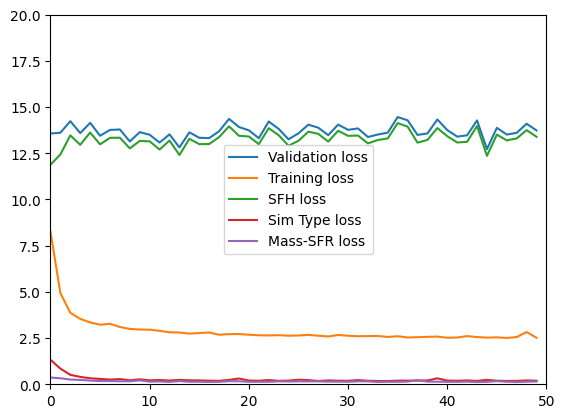

In [14]:
plt.plot(val_losses, label='Validation loss')
plt.plot(losses, label='Training loss')
plt.plot(losses_sfh, label='SFH loss')
plt.plot(losses_sim_type, label='Sim Type loss')
plt.plot(losses_mass_sfr, label='Mass-SFR loss')
plt.xlim(0, 50)
plt.ylim(0, 20)
plt.legend()

In [15]:
with torch.no_grad():
    y_pred_tensor = AE(SFH_test_tensor.unsqueeze(1).to(device))
    latent_space_tensor = AE.encoder(SFH_test_tensor.unsqueeze(1).to(device))

In [16]:
latent_space = latent_space_tensor.detach().cpu().numpy()
SFH_pred = y_pred_tensor[0].detach().cpu().numpy()
sim_pred = y_pred_tensor[1].detach().cpu().numpy()
SMSFR_pred = y_pred_tensor[2].detach().cpu().numpy()

In [17]:
def un_one_hot(one_hot_array):
    return np.argmax(one_hot_array, axis=-1)
sim_pred = un_one_hot(sim_pred)

In [18]:
correct = 0
for i in range(len(sim_pred)):
    if np.array_equal(sim_pred[i], labels_test[i]):
        correct += 1

print(correct / len(sim_pred))

0.9356423872552905


In [19]:
import umap
reducer = umap.UMAP(n_components=2, n_neighbors=200)
embedding = reducer.fit_transform(latent_space)
embedding.shape

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(12617, 2)

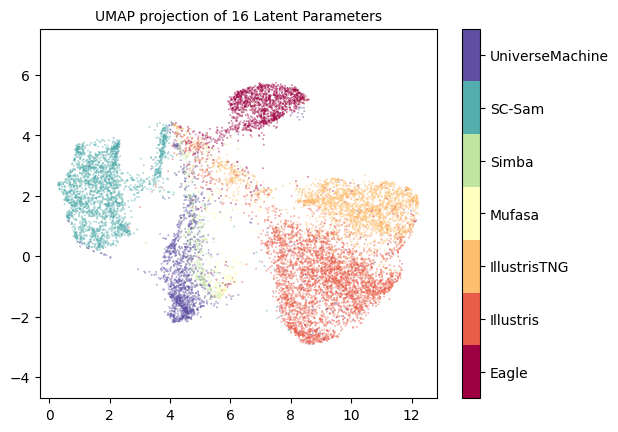

In [20]:
labels = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine']

plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_test, cmap='Spectral', s=0.05)
plt.gca().set_aspect('equal', 'datalim')

# Create a colorbar
cbar = plt.colorbar(boundaries=np.arange(8)-0.5, ticks=np.arange(7))

# Set the colorbar labels
cbar.ax.set_yticklabels(labels)

plt.title('UMAP projection of 16 Latent Parameters', fontsize=10)
plt.show()

In [22]:
torch.save(AE, "model0206.pth")